In [ ]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

with open('region_dataset.pkl', 'rb') as f:
    dataset = pickle.load(f)

first_sample = dataset[0]
print("Detailed information for each key in the first sample:")

for key, value in first_sample.items():
    print(f"\nKey: {key}")
    print(f"  Type: {type(value)}")

    if isinstance(value, np.ndarray):
        print(f"  Shape: {value.shape}")
        print(f"  Dtype: {value.dtype}")
        flat_val = value.flatten()
        sample_str = np.array2string(flat_val[:min(10, flat_val.size)], separator=', ')
        print(f"  Sample values: {sample_str}")

    elif isinstance(value, list):
        print(f"  Length: {len(value)}")
        if len(value) > 0:
            first_elem = value[0]
            print(f"  First element: {first_elem} (type: {type(first_elem)})")

    else:
        print(f"  Value: {value}")


Detailed information for each key in the first sample:

Key: best_IRS_idx_grid
  Type: <class 'numpy.ndarray'>
  Shape: (100, 100)
  Dtype: int64
  Sample values: [1, 1, 1, 1, 1, 1, 2, 2, 2, 2]

Key: Pos_BS
  Type: <class 'numpy.ndarray'>
  Shape: (3,)
  Dtype: float64
  Sample values: [ 5.,  5., 10.]

Key: candidate_IRS
  Type: <class 'numpy.ndarray'>
  Shape: (4, 3)
  Dtype: float64
  Sample values: [4.14548736, 3.95857613, 5.        , 3.36960811, 2.06096457, 5.        ,
 2.63049757, 8.28730747, 5.        , 1.20817092]

Key: plot_file
  Type: <class 'str'>
  Value: region_plot_0.png


In [ ]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

with open('region_dataset.pkl', 'rb') as f:
    dataset = pickle.load(f)

irs_grid = dataset[0]['best_IRS_idx_grid']


print("IRS Selection Grid (Entire Grid):")
print(irs_grid)

plt.figure(figsize=(8, 8))
plt.imshow(irs_grid, origin='lower', cmap='viridis')
plt.title("IRS Selection Grid")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.colorbar(label="IRS Index")
plt.show()


UnpicklingError: pickle data was truncated

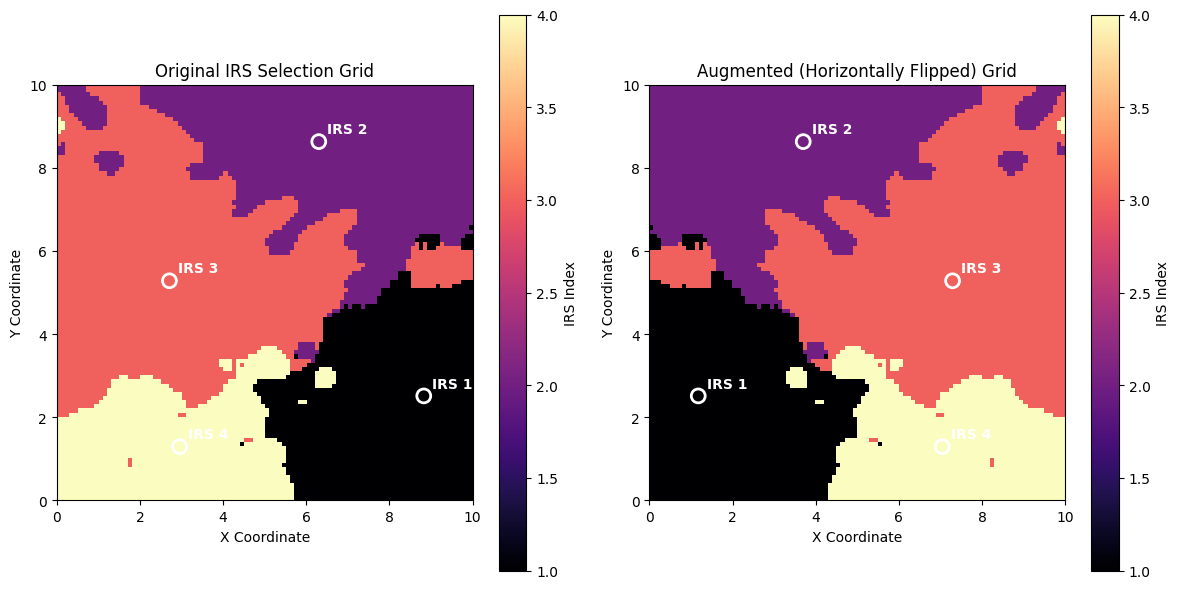

In [ ]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import random

def augment_horizontal_flip(sample, region_bounds=(0, 10, 0, 10)):
    """
    Horizontally flips the sample, ensuring that both the best_IRS_idx_grid and the positional
    data (Pos_BS and candidate_IRS) are transformed consistently.

    Parameters:
        sample (dict): Contains keys 'best_IRS_idx_grid', 'Pos_BS', and 'candidate_IRS'.
        region_bounds (tuple): (x_min, x_max, y_min, y_max) defining the region.

    Returns:
        new_sample (dict): Augmented sample with horizontally flipped grid and updated positions.
    """
    x_min, x_max, y_min, y_max = region_bounds

    new_grid = np.fliplr(sample['best_IRS_idx_grid'])

    new_bs = sample['Pos_BS'].copy()
    new_bs[0] = x_min + x_max - new_bs[0]

    new_candidate_IRS = sample['candidate_IRS'].copy()
    new_candidate_IRS[:, 0] = x_min + x_max - new_candidate_IRS[:, 0]

    new_sample = sample.copy()
    new_sample['best_IRS_idx_grid'] = new_grid
    new_sample['Pos_BS'] = new_bs
    new_sample['candidate_IRS'] = new_candidate_IRS

    return new_sample


with open('region_dataset.pkl', 'rb') as f:
    dataset = pickle.load(f)

random_sample = random.choice(dataset)

augmented_sample = augment_horizontal_flip(random_sample)

original_grid = random_sample['best_IRS_idx_grid']
augmented_grid = augmented_sample['best_IRS_idx_grid']

orig_candidate_positions = random_sample['candidate_IRS']
aug_candidate_positions = augmented_sample['candidate_IRS']

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(original_grid, origin='lower', cmap='magma', extent=[0, 10, 0, 10])
plt.title("Original IRS Selection Grid")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.colorbar(label="IRS Index")

for idx, pos in enumerate(orig_candidate_positions):
    x, y = pos[0], pos[1]
    plt.scatter(x, y, marker='o', edgecolor='white', facecolor='none', s=100, linewidths=2)
    plt.text(x+0.2, y+0.2, f"IRS {idx+1}", color='white', fontsize=10, weight='bold')

plt.subplot(1, 2, 2)
plt.imshow(augmented_grid, origin='lower', cmap='magma', extent=[0, 10, 0, 10])
plt.title("Augmented (Horizontally Flipped) Grid")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.colorbar(label="IRS Index")

for idx, pos in enumerate(aug_candidate_positions):
    x, y = pos[0], pos[1]
    plt.scatter(x, y, marker='o', edgecolor='white', facecolor='none', s=100, linewidths=2)
    plt.text(x+0.2, y+0.2, f"IRS {idx+1}", color='white', fontsize=10, weight='bold')

plt.tight_layout()
plt.show()


In [ ]:
import torch
from torch.utils.data import Dataset
import pickle
import numpy as np
import random

GRID_SIZE = 100
x_min, x_max, y_min, y_max = 0, 10, 0, 10
x = np.linspace(x_min, x_max, GRID_SIZE)
y = np.linspace(y_min, y_max, GRID_SIZE)
xv, yv = np.meshgrid(x, y)

def compute_distance_map(point, xv, yv):
    """
    Computes the Euclidean distance from each (x,y) grid point to the given point.

    Args:
        point (array-like): [x, y, z] (only x and y are used).
        xv, yv (ndarray): Meshgrid arrays of the x and y coordinates.

    Returns:
        ndarray: A (GRID_SIZE, GRID_SIZE) array of distances.
    """
    return np.sqrt((xv - point[0])**2 + (yv - point[1])**2)

def create_input_tensor_from_positions(sample):
    """
    Creates an input tensor from the positional data in the sample.

    Returns:
        ndarray: A stacked tensor of shape (5, GRID_SIZE, GRID_SIZE) where:
                 - Channel 0 is the distance map for the Base Station.
                 - Channels 1-4 are the distance maps for each candidate IRS.
    """

    bs_map = compute_distance_map(sample['Pos_BS'], xv, yv)
    irs_maps = [compute_distance_map(irs, xv, yv) for irs in sample['candidate_IRS']]
    input_tensor = np.stack([bs_map] + irs_maps, axis=0)
    return input_tensor

REGION_BOUNDS = (0, 10, 0, 10)

def augment_horizontal_flip(sample, region_bounds=REGION_BOUNDS):
    x_min, x_max, _, _ = region_bounds
    new_grid = np.fliplr(sample['best_IRS_idx_grid'])
    new_bs = sample['Pos_BS'].copy()
    new_bs[0] = x_min + x_max - new_bs[0]
    new_candidate_IRS = sample['candidate_IRS'].copy()
    new_candidate_IRS[:, 0] = x_min + x_max - new_candidate_IRS[:, 0]
    new_sample = sample.copy()
    new_sample['best_IRS_idx_grid'] = new_grid
    new_sample['Pos_BS'] = new_bs
    new_sample['candidate_IRS'] = new_candidate_IRS
    return new_sample

def augment_vertical_flip(sample, region_bounds=REGION_BOUNDS):
    _, _, y_min, y_max = region_bounds
    new_grid = np.flipud(sample['best_IRS_idx_grid'])
    new_bs = sample['Pos_BS'].copy()
    new_bs[1] = y_min + y_max - new_bs[1]
    new_candidate_IRS = sample['candidate_IRS'].copy()
    new_candidate_IRS[:, 1] = y_min + y_max - new_candidate_IRS[:, 1]
    new_sample = sample.copy()
    new_sample['best_IRS_idx_grid'] = new_grid
    new_sample['Pos_BS'] = new_bs
    new_sample['candidate_IRS'] = new_candidate_IRS
    return new_sample

def augment_rotate_90(sample, region_bounds=REGION_BOUNDS):
    x_min, x_max, y_min, y_max = region_bounds
    cx, cy = (x_min + x_max) / 2, (y_min + y_max) / 2
    new_grid = np.rot90(sample['best_IRS_idx_grid'], k=-1)
    def rotate_point(xy):
        x, y = xy
        x_shifted, y_shifted = x - cx, y - cy
        x_rot = y_shifted + cx
        y_rot = -x_shifted + cy
        return np.array([x_rot, y_rot])
    bs = sample['Pos_BS'].copy()
    bs[:2] = rotate_point(bs[:2])
    irs = sample['candidate_IRS'].copy()
    for i in range(irs.shape[0]):
        irs[i, :2] = rotate_point(irs[i, :2])
    new_sample = sample.copy()
    new_sample['best_IRS_idx_grid'] = new_grid
    new_sample['Pos_BS'] = bs
    new_sample['candidate_IRS'] = irs
    return new_sample

def random_augmentation(sample):
    aug_type = random.choice(['none', 'h_flip', 'v_flip', 'rotate'])
    if aug_type == 'h_flip':
        return augment_horizontal_flip(sample)
    elif aug_type == 'v_flip':
        return augment_vertical_flip(sample)
    elif aug_type == 'rotate':
        return augment_rotate_90(sample)
    else:
        return sample

class IRSRawAugmentedDataset(Dataset):
    def __init__(self, pkl_file="region_dataset.pkl", augment=True, augment_factor=4):
        """
        Args:
            pkl_file (str): Path to the pickle file containing the dataset.
            augment (bool): Whether to apply augmentation.
            augment_factor (int): Number of times to replicate each sample with augmentation.
        """
        with open(pkl_file, "rb") as f:
            self.data = pickle.load(f)
        self.augment = augment
        self.augment_factor = augment_factor

    def __len__(self):
        return len(self.data) * self.augment_factor

    def __getitem__(self, idx):
        original_idx = idx // self.augment_factor
        sample = self.data[original_idx]
        if self.augment:
            sample = random_augmentation(sample)
        input_tensor = create_input_tensor_from_positions(sample)
        label = sample['best_IRS_idx_grid'] - 1

        return {
            "input": torch.tensor(input_tensor, dtype=torch.float32),
            "label": torch.tensor(label, dtype=torch.long),
            "Pos_BS": sample['Pos_BS'],
            "candidate_IRS": sample['candidate_IRS']
        }


In [ ]:
dataset = IRSRawAugmentedDataset("region_dataset.pkl", augment=True)
print("Number of datapoints in dataset:", len(dataset))

Number of datapoints in dataset: 7656


In [ ]:
import torch.nn as nn

class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.block(x)

class SimpleUNet(nn.Module):
    def __init__(self, in_ch=5, out_ch=4):
        super().__init__()
        self.enc1 = ConvBlock(in_ch, 32)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = ConvBlock(32, 64)
        self.pool2 = nn.MaxPool2d(2)

        self.bottleneck = ConvBlock(64, 128)

        self.up2 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec2 = ConvBlock(128, 64)
        self.up1 = nn.ConvTranspose2d(64, 32, 2, stride=2)
        self.dec1 = ConvBlock(64, 32)

        self.out_conv = nn.Conv2d(32, out_ch, 1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))
        b = self.bottleneck(self.pool2(e2))
        d2 = self.dec2(torch.cat([self.up2(b), e2], dim=1))
        d1 = self.dec1(torch.cat([self.up1(d2), e1], dim=1))
        return self.out_conv(d1)  # (B, 4, 100, 100)


In [ ]:
import torch
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pickle

with open("region_dataset.pkl", "rb") as f:
    original_data = pickle.load(f)
fixed_indices = np.random.choice(len(original_data), 4, replace=False)
fixed_samples = []
for idx in fixed_indices:
    sample = original_data[idx]
    input_tensor = create_input_tensor_from_positions(sample)
    label = sample["best_IRS_idx_grid"] - 1
    fixed_samples.append({
        "input": torch.tensor(input_tensor, dtype=torch.float32),
        "label": torch.tensor(label, dtype=torch.long),
        "Pos_BS": sample["Pos_BS"],
        "candidate_IRS": sample["candidate_IRS"]
    })

dataset = IRSRawAugmentedDataset("region_dataset.pkl", augment=True)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=8)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleUNet(in_ch=5, out_ch=4).to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

base_station_marker = '^'
base_station_color = 'red'
irs_colors = ['green', 'blue', 'orange', 'cyan']

epochs = 200
for epoch in range(epochs):
    model.train()
    train_loss = 0
    print(f"\nEpoch {epoch+1}/{epochs}")

    for batch in tqdm(train_loader, desc="Training", leave=False):
        x = batch["input"].to(device)
        y = batch["label"].to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    print(f"→ Train Loss: {train_loss / len(train_loader):.4f}")
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Validation", leave=False):
            x = batch["input"].to(device)
            y = batch["label"].to(device)
            out = model(x)
            loss = criterion(out, y)
            val_loss += loss.item()
    print(f"→ Val Loss:   {val_loss / len(val_loader):.4f}")
    model.eval()
    with torch.no_grad():
        fig, axs = plt.subplots(4, 2, figsize=(12, 20))
        plt.suptitle(f"Epoch {epoch+1} - Fixed Validation Samples", fontsize=16, y=0.92)

        for i, sample in enumerate(fixed_samples):
            x_fixed = sample["input"].unsqueeze(0).to(device)
            y_fixed = sample["label"].to(device)
            out_fixed = model(x_fixed)
            pred_fixed = torch.argmax(out_fixed, dim=1).squeeze(0).cpu().numpy()
            gt_fixed = y_fixed.cpu().numpy()
            ax_gt = axs[i, 0]
            im_gt = ax_gt.imshow(
                gt_fixed,
                cmap='magma',
                vmin=0, vmax=3,
                origin='lower',
                extent=[0, 10, 0, 10]
            )
            ax_gt.set_title(f"Sample {i+1} Ground Truth", fontsize=12)
            ax_gt.set_xlabel("User X Position")
            ax_gt.set_ylabel("User Y Position")
            cbar_gt = plt.colorbar(im_gt, ax=ax_gt, fraction=0.046, pad=0.04)
            cbar_gt.set_label("Best IRS Index", fontsize=10)
            bs_x, bs_y, _ = sample["Pos_BS"]
            ax_gt.scatter(bs_x, bs_y,
                          marker=base_station_marker,
                          color=base_station_color,
                          s=150,
                          label=f"Base Station [BS: {bs_x:.1f}, {bs_y:.1f}]")
            for j, pos in enumerate(sample["candidate_IRS"]):
                ax_gt.scatter(pos[0], pos[1],
                              marker='s',
                              color=irs_colors[j % len(irs_colors)],
                              s=80,
                              label=f"IRS {j+1}: [{pos[0]:.1f}, {pos[1]:.1f}]")
            ax_gt.legend(loc='upper right', fontsize=8)
            ax_pred = axs[i, 1]
            im_pred = ax_pred.imshow(
                pred_fixed,
                cmap='magma',
                vmin=0, vmax=3,
                origin='lower',
                extent=[0, 10, 0, 10]
            )
            ax_pred.set_title(f"Sample {i+1} Prediction", fontsize=12)
            ax_pred.set_xlabel("User X Position")
            ax_pred.set_ylabel("User Y Position")
            cbar_pred = plt.colorbar(im_pred, ax=ax_pred, fraction=0.046, pad=0.04)
            cbar_pred.set_label("Best IRS Index", fontsize=10)
            ax_pred.scatter(bs_x, bs_y,
                            marker=base_station_marker,
                            color=base_station_color,
                            s=150,
                            label=f"Base Station [BS: {bs_x:.1f}, {bs_y:.1f}]")
            for j, pos in enumerate(sample["candidate_IRS"]):
                ax_pred.scatter(pos[0], pos[1],
                                marker='s',
                                color=irs_colors[j % len(irs_colors)],
                                s=80,
                                label=f"IRS {j+1}: [{pos[0]:.1f}, {pos[1]:.1f}]")

            ax_pred.legend(loc='upper right', fontsize=8)

        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()
    torch.save(model.state_dict(), f"model_epoch_{epoch+1}.pth")


KeyboardInterrupt: 

In [ ]:
import torch
import random
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleUNet(in_ch=5, out_ch=4).to(device)
model.load_state_dict(torch.load("model_epoch_30.pth", map_location=device))
model.eval()

num_samples = 10
val_indices = random.sample(range(len(val_ds)), num_samples)

fig, axs = plt.subplots(num_samples, 2, figsize=(12, num_samples * 3))
fig.suptitle("Validation Samples: Ground Truth vs. Predictions (Model Epoch 30)", fontsize=16, y=0.92)

for i, idx in enumerate(val_indices):
    sample = val_ds[idx]

    x = sample["input"].unsqueeze(0).to(device)
    y = sample["label"].to(device)

    with torch.no_grad():
        out = model(x)
    pred = torch.argmax(out, dim=1).squeeze(0).cpu().numpy()
    gt = y.cpu().numpy()
    axs[i, 0].imshow(gt, cmap='magma', vmin=0, vmax=3, origin='lower', extent=[0,10,0,10])
    axs[i, 0].set_title(f"Sample {i+1} Ground Truth")
    axs[i, 0].set_xlabel("User X Position")
    axs[i, 0].set_ylabel("User Y Position")
    for pos in sample["candidate_IRS"]:
        axs[i, 0].scatter(pos[0], pos[1], marker='s', s=50, edgecolors='white',
                          facecolors='none', linewidths=2)
    axs[i, 1].imshow(pred, cmap='magma', vmin=0, vmax=3, origin='lower', extent=[0,10,0,10])
    axs[i, 1].set_title(f"Sample {i+1} Prediction")
    axs[i, 1].set_xlabel("User X Position")
    axs[i, 1].set_ylabel("User Y Position")
    for pos in sample["candidate_IRS"]:
        axs[i, 1].scatter(pos[0], pos[1], marker='s', s=50, edgecolors='white',
                          facecolors='none', linewidths=2)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


NameError: name 'val_ds' is not defined

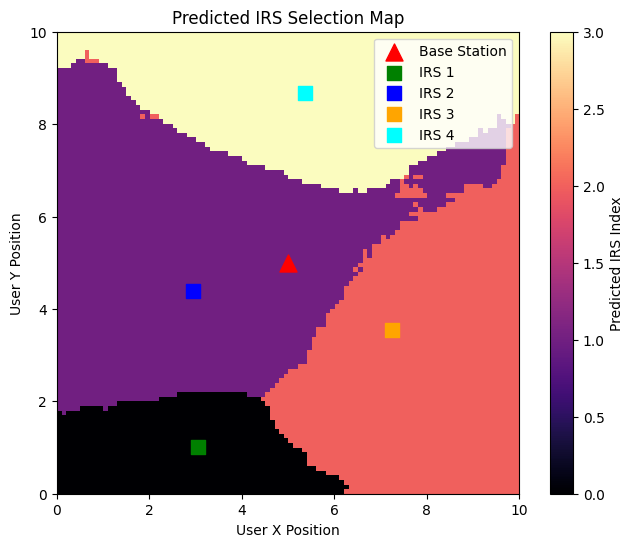

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
GRID_SIZE = 100
x_min, x_max = 0, 10
y_min, y_max = 0, 10
x = np.linspace(x_min, x_max, GRID_SIZE)
y = np.linspace(y_min, y_max, GRID_SIZE)
xv, yv = np.meshgrid(x, y)

def compute_distance_map(point, xv, yv):
    """
    Computes the Euclidean distance from each grid point (xv, yv) to the given point.
    Only the x,y components of point are used.
    """
    return np.sqrt((xv - point[0])**2 + (yv - point[1])**2)

def create_input_tensor_from_positions(sample):
    """
    Creates an input tensor from the sample's positional data.
    - Channel 0: Distance map for the Base Station.
    - Channels 1-4: Distance maps for the 4 candidate IRSs.

    Returns:
        A NumPy array of shape (5, 100, 100).
    """
    bs_map = compute_distance_map(sample['Pos_BS'], xv, yv)
    irs_maps = [compute_distance_map(irs, xv, yv) for irs in sample['candidate_IRS']]
    input_tensor = np.stack([bs_map] + irs_maps, axis=0)
    return input_tensor

def generate_candidate_IRS(num=4, region_bounds=(0,10,0,10), min_dist=3):
    """
    Randomly generates 'num' candidate IRS positions within the x-y region [x_min,x_max] x [y_min,y_max]
    such that each candidate is at least 'min_dist' units away from every other (based on x,y distance).
    Each IRS is assigned a z value of 5.

    Returns:
        A NumPy array of shape (num, 3).
    """
    x_min, x_max, y_min, y_max = region_bounds
    positions = []
    while len(positions) < num:
        candidate = np.array([np.random.uniform(x_min, x_max),
                              np.random.uniform(y_min, y_max),
                              5.0])
        if all(np.linalg.norm(candidate[:2] - pos[:2]) >= min_dist for pos in positions):
            positions.append(candidate)
    return np.array(positions)


Pos_BS = np.array([5, 5, 10])
candidate_IRS = generate_candidate_IRS(num=4, region_bounds=(0,10,0,10), min_dist=3)
dummy_grid = np.zeros((GRID_SIZE, GRID_SIZE), dtype=int)
sample = {
    "Pos_BS": Pos_BS,
    "candidate_IRS": candidate_IRS,
    "best_IRS_idx_grid": dummy_grid
}

input_tensor = create_input_tensor_from_positions(sample)
input_tensor_torch = torch.tensor(input_tensor, dtype=torch.float32).unsqueeze(0).to(device)
model = SimpleUNet(in_ch=5, out_ch=4).to(device)
model.load_state_dict(torch.load("model_epoch_50.pth", map_location=device))
model.eval()


with torch.no_grad():
    output = model(input_tensor_torch)
    predicted_map = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()
plt.figure(figsize=(8, 6))
plt.imshow(predicted_map, cmap='magma', vmin=0, vmax=3, origin='lower', extent=[0,10,0,10])
plt.colorbar(label="Predicted IRS Index")
plt.title("Predicted IRS Selection Map")

plt.scatter(Pos_BS[0], Pos_BS[1], marker='^', color='red', s=150, label="Base Station")

irs_colors = ['green', 'blue', 'orange', 'cyan']
for i, pos in enumerate(candidate_IRS):
    plt.scatter(pos[0], pos[1], marker='s', color=irs_colors[i % len(irs_colors)], s=100, label=f"IRS {i+1}")

plt.xlabel("User X Position")
plt.ylabel("User Y Position")
plt.legend(loc='upper right')
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import random
import MuMIMOClassLoss
from math import pi, sqrt

user_height = 1.5
num_samples = 100
NumAntBS = 2
NumEleIRS = 32
NumUser = 1
sigma2_BS = 0.1
sigma2_UE = 0.5

Pos_BS = np.array([5.0, 5.0, 10.0])

def generate_candidate_IRS(num=4, x_range=(1,9), y_range=(1,9), min_dist=3):
    positions = []
    while len(positions) < num:
        candidate = np.array([np.random.uniform(*x_range),
                              np.random.uniform(*y_range),
                              5.0])
        if all(np.linalg.norm(candidate[:2] - pos[:2]) >= min_dist for pos in positions):
            positions.append(candidate)
    return np.array(positions)

Candidate_IRS = generate_candidate_IRS(num=4, x_range=(1,9), y_range=(1,9), min_dist=3)

GRID_SIZE = 100
x_vals = np.linspace(0, 10, GRID_SIZE)
y_vals = np.linspace(0, 10, GRID_SIZE)
xv, yv = np.meshgrid(x_vals, y_vals)

def compute_distance_map(point, xv, yv):
    return np.sqrt((xv - point[0])**2 + (yv - point[1])**2)

def create_input_tensor_from_positions(sample):
    """
    Returns a 5-channel input tensor (BS distance map, plus 4 IRS distance maps)
    with shape (5, 100, 100).
    """
    bs_map = compute_distance_map(sample["Pos_BS"], xv, yv)
    irs_maps = [compute_distance_map(irs, xv, yv) for irs in sample["candidate_IRS"]]
    input_tensor = np.stack([bs_map] + irs_maps, axis=0)
    return input_tensor


sample_region = {
    "Pos_BS": Pos_BS,
    "candidate_IRS": Candidate_IRS,
    "best_IRS_idx_grid": np.zeros((GRID_SIZE, GRID_SIZE))
}

region_input = create_input_tensor_from_positions(sample_region)
region_input_torch = torch.tensor(region_input, dtype=torch.float32).unsqueeze(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SimpleUNet(in_ch=5, out_ch=4).to(device)
model.load_state_dict(torch.load("/content/model_epoch_30.pth", map_location=device))
model.eval()

with torch.no_grad():
    output_region = model(region_input_torch.to(device))
    pred_region = torch.argmax(output_region, dim=1).squeeze(0).cpu().numpy()


x_line = np.linspace(2, 8, num_samples)
y_line = np.linspace(8, 8, num_samples)


def moving_average(data, window_size=2):
    return np.convolve(data, np.ones(window_size) / window_size, mode='same')

def optimize_IRS(irs_pos, Pos_UE):
    env_instance = envMuMIMO(NumAntBS, NumEleIRS, NumUser, path_loss_exponent=3.0, reference_distance=2.5)
    ArrayShape_BS = [NumAntBS, 1, 1]
    ArrayShape_IRS = [1, NumEleIRS, 1]
    ArrayShape_UE = [1, 1, 1]
    Pilot = env_instance.DFT_matrix(NumUser)

    H_U2B_LoS, H_R2B_LoS, H_U2R_LoS = env_instance.H_GenFunLoS(Pos_BS, irs_pos, Pos_UE,
                                                                ArrayShape_BS, ArrayShape_IRS, ArrayShape_UE)
    RefVector = np.exp(1j * np.zeros((1, NumEleIRS)))
    ShiftCodebook = np.array([
        np.exp(1j * pi * 2 * np.arange(NumEleIRS) / NumEleIRS),
        np.exp(-1j * pi * 2 * np.arange(NumEleIRS) / NumEleIRS),
        np.exp(3j * pi * 2 * np.arange(NumEleIRS) / NumEleIRS),
        np.exp(-3j * pi * 2 * np.arange(NumEleIRS) / NumEleIRS),
        np.exp(0j * pi * 2 * np.arange(NumEleIRS) / NumEleIRS)
    ])
    random_action = random.randrange(ShiftCodebook.shape[0])
    RefVector = RefVector * ShiftCodebook[random_action, :]
    H_synt = env_instance.H_syntFun(H_U2B_LoS, H_R2B_LoS, H_U2R_LoS, RefVector[0])
    Rate, _, _ = env_instance.GetRewards(Pilot, H_synt, sigma2_BS, sigma2_UE)
    sum_rate = np.sum(Rate)
    return sum_rate

bitrate_per_irs = np.zeros((num_samples, 4))

for i, (x, y) in enumerate(zip(x_line, y_line)):
    Pos_UE = np.array([[x, y, user_height]], dtype=np.float64)
    sum_rates = [optimize_IRS(irs_pos, Pos_UE) for irs_pos in Candidate_IRS]
    bitrate_per_irs[i, :] = sum_rates

best_irs_selection = np.argmax(bitrate_per_irs, axis=1) + 1
smooth_window = 10
bitrate_smoothed = np.zeros_like(bitrate_per_irs)
for j in range(4):
    bitrate_smoothed[:, j] = moving_average(bitrate_per_irs[:, j], smooth_window)

fig, axs = plt.subplots(1, 2, figsize=(16, 6))
im = axs[0].imshow(pred_region, cmap='magma', vmin=0, vmax=3, origin='lower', extent=[0, 10, 0, 10])
axs[0].set_title("Predicted IRS Selection Map")
axs[0].set_xlabel("User X Position")
axs[0].set_ylabel("User Y Position")
plt.colorbar(im, ax=axs[0], label="IRS Index")
axs[0].plot(x_line, y_line, color='white', linewidth=2, linestyle='--', label="Path Taken")
axs[0].scatter(Pos_BS[0], Pos_BS[1], marker='^', color='red', s=150, label="Base Station")
irs_colors = ['green', 'blue', 'orange', 'cyan']
for i, pos in enumerate(Candidate_IRS):
    axs[0].scatter(pos[0], pos[1], marker='s', color=irs_colors[i % len(irs_colors)], s=150, label=f"IRS {i+1}")
axs[0].legend(loc='upper right', fontsize=8)

for j in range(4):
    axs[1].plot(range(num_samples), bitrate_smoothed[:, j], label=f'IRS {j+1}')
axs[1].set_xlabel("Sample Position Along Path")
axs[1].set_ylabel("Bitrate (bps/Hz)")
axs[1].set_title("Smoothed Bitrate Transition Across IRS Candidates")
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()



NameError: name 'envMuMIMO' is not defined

In [ ]:
import torch.nn as nn

class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.block(x)

class SimpleUNet(nn.Module):
    def __init__(self, in_ch=5, out_ch=4):
        super().__init__()
        self.enc1 = ConvBlock(in_ch, 32)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = ConvBlock(32, 64)
        self.pool2 = nn.MaxPool2d(2)

        self.bottleneck = ConvBlock(64, 128)

        self.up2 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec2 = ConvBlock(128, 64)
        self.up1 = nn.ConvTranspose2d(64, 32, 2, stride=2)
        self.dec1 = ConvBlock(64, 32)

        self.out_conv = nn.Conv2d(32, out_ch, 1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))
        b = self.bottleneck(self.pool2(e2))
        d2 = self.dec2(torch.cat([self.up2(b), e2], dim=1))
        d1 = self.dec1(torch.cat([self.up1(d2), e1], dim=1))
        return self.out_conv(d1)  # (B, 4, 100, 100)


Saved map to irs_selection_map_discrete_magma.pdf


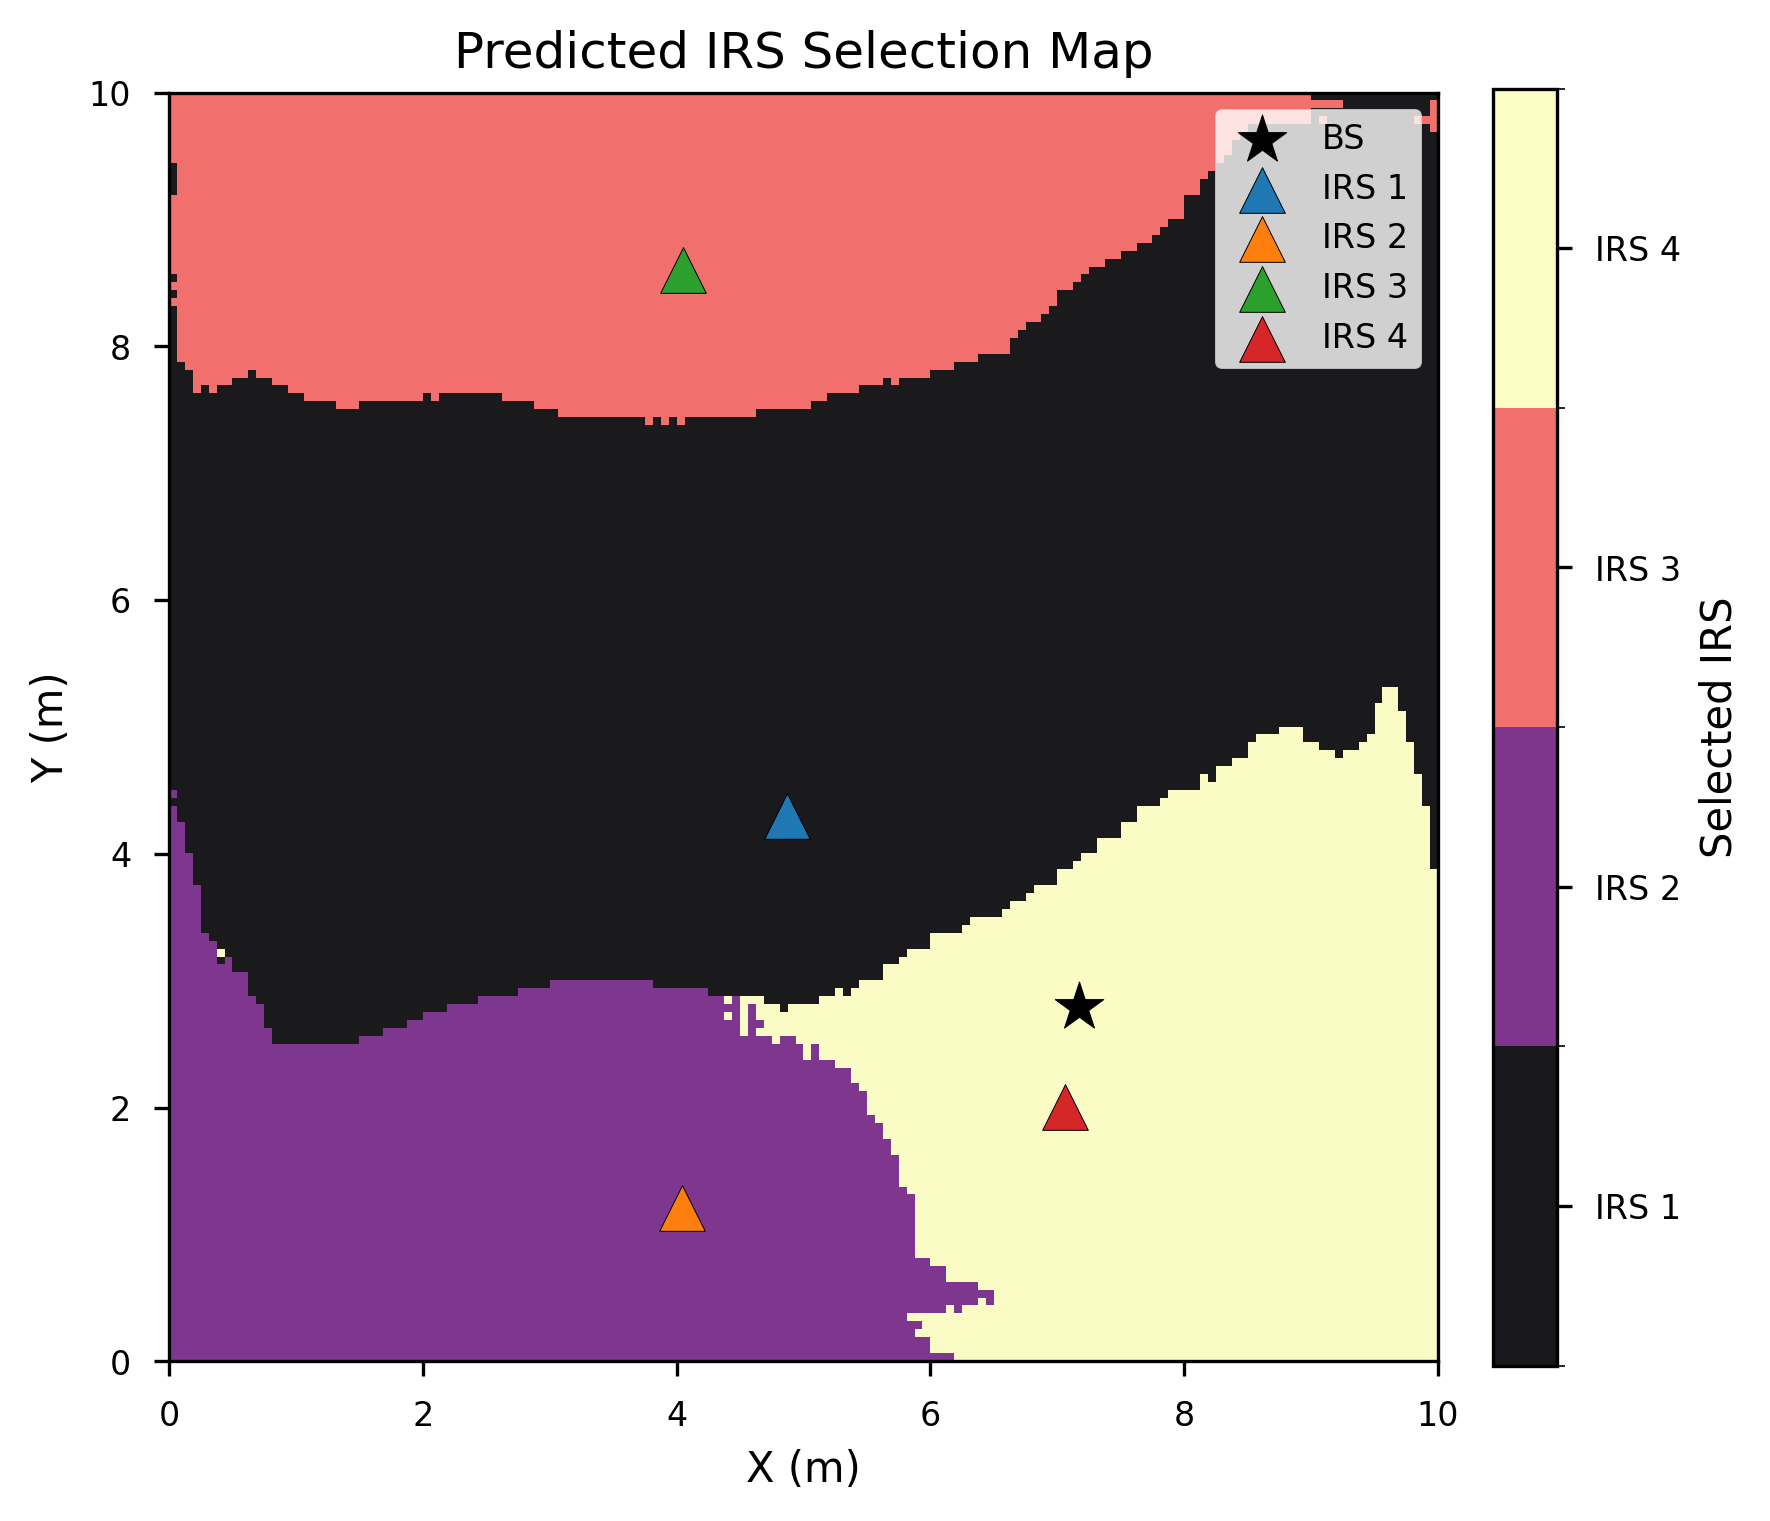

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
plt.style.use('seaborn-v0_8-paper')   # seaborn paper style

from MuMIMOClassLoss import envMuMIMO
import random
from math import pi

# --- SETUP ---
MODEL_PATH = "model_epoch_30.pth"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SimpleUNet(in_ch=5, out_ch=4).to(device)
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.eval()

# --- REGION CONFIG ---
GRID_SIZE = 160
x_min, x_max = 0, 10
y_min, y_max = 0, 10
x = np.linspace(x_min, x_max, GRID_SIZE)
y = np.linspace(y_min, y_max, GRID_SIZE)
xv, yv = np.meshgrid(x, y)

# --- RANDOMIZED POSITIONS WITH SPACING ---
Pos_BS = np.array([
    np.random.uniform(x_min + 2, x_max - 2),
    np.random.uniform(y_min + 2, y_max - 2),
    2
])

def generate_IRS_positions(n=4, min_dist=2.5, max_trials=100):
    irs_positions = []
    trials = 0
    while len(irs_positions) < n and trials < max_trials:
        new_pos = np.array([
            np.random.uniform(x_min + 1, x_max - 1),
            np.random.uniform(y_min + 1, y_max - 1),
            2
        ])
        if all(np.linalg.norm(new_pos[:2] - p[:2]) >= min_dist
               for p in irs_positions):
            irs_positions.append(new_pos)
        trials += 1
    if len(irs_positions) < n:
        print(f"⚠️ Only placed {len(irs_positions)} IRSs after {max_trials} trials.")
    return np.array(irs_positions)

candidate_IRS = generate_IRS_positions(n=4, min_dist=2.5)

# --- DISTANCE MAP GENERATION ---
def compute_distance_map(point, xv, yv):
    return np.sqrt((xv - point[0])**2 + (yv - point[1])**2)

bs_map = compute_distance_map(Pos_BS, xv, yv)
irs_maps = [compute_distance_map(irs, xv, yv) for irs in candidate_IRS]

input_tensor_np = np.stack([bs_map] + irs_maps, axis=0)  # (5, H, W)
input_tensor = torch.tensor(input_tensor_np, dtype=torch.float32)\
                   .unsqueeze(0).to(device)

# --- INFERENCE ---
with torch.no_grad():
    output = model(input_tensor)               # (1, 4, H, W)
    prediction = torch.argmax(output, dim=1)\
                     .squeeze().cpu().numpy()  # (H, W)

# --- PLOTTING WITH DISCRETE MAGMA REGIONS & BRIGHT IRS MARKERS ---
# create a discrete "magma" colormap with 4 bins
magma_colors = plt.cm.magma(np.linspace(0, 1, 4))
cmap = ListedColormap(magma_colors)
norm = BoundaryNorm(boundaries=[-0.5, 0.5, 1.5, 2.5, 3.5], ncolors=4)

# grab the four default bright colors for EMS markers
marker_colors = plt.rcParams['axes.prop_cycle'].by_key()['color'][:4]

fig, ax = plt.subplots(figsize=(6, 6), dpi=300)

# discreteMAGMA selection map
im = ax.imshow(
    prediction,
    origin='lower',
    extent=[x_min, x_max, y_min, y_max],
    cmap=cmap,
    norm=norm,
    alpha=0.9
)

# discrete colorbar blocks
cbar = fig.colorbar(
    im, ax=ax,
    ticks=[0, 1, 2, 3],
    boundaries=[-0.5, 0.5, 1.5, 2.5, 3.5],
    spacing='proportional',
    fraction=0.046,
    pad=0.04
)
cbar.ax.set_yticklabels([f"IRS {i+1}" for i in range(4)])
cbar.set_label("Selected IRS", fontsize=10)

# Base Station marker
ax.scatter(
    Pos_BS[0], Pos_BS[1],
    marker='*', s=150,
    edgecolor='k', color='black',
    label='BS', zorder=5
)

# IRS markers with bright colors
for idx, pos in enumerate(candidate_IRS):
    ax.scatter(
        pos[0], pos[1],
        marker='^', s=120,
        edgecolor='k', color=marker_colors[idx],
        label=f'IRS {idx+1}', zorder=5
    )

# formatting
ax.set_title("Predicted IRS Selection Map", fontsize=12)
ax.set_xlabel("X (m)", fontsize=10)
ax.set_ylabel("Y (m)", fontsize=10)
ax.legend(frameon=True, fontsize=8, loc='upper right')
ax.grid(False)

plt.tight_layout()
# Save high-quality PDF
fig.savefig("irs_selection_map_discrete_magma.pdf", bbox_inches='tight')
print("Saved map to irs_selection_map_discrete_magma.pdf")

plt.show()


In [ ]:
from google.colab import files
files.download("irs_selection_map_discrete_magma.pdf")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Top-1 Accuracy: 80.00%
Top-2 Accuracy: 93.00%
Saved figure to irs_and_bitrate_discrete_magma_matched.pdf


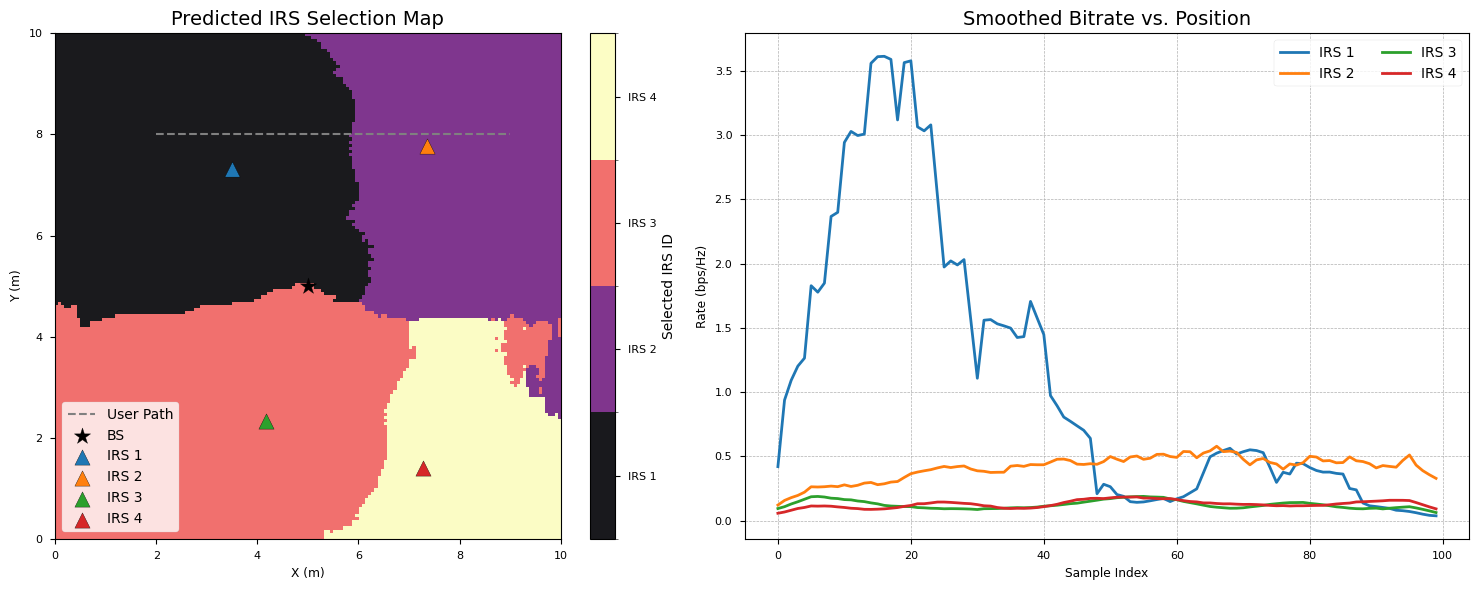

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
plt.style.use('seaborn-v0_8-paper')   # use the seaborn paper style

from MuMIMOClassLoss import envMuMIMO
import random
from math import pi

# --- CONFIG ---
GRID_SIZE = 160
x_min, x_max = 0, 10
y_min, y_max = 0, 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

NumAntBS = 2
NumEleIRS = 32
NumUser = 1
sigma2_BS = 0.1
sigma2_UE = 0.5
user_height = 1.5
num_samples = 100

# --- Generate BS and IRS Positions ---
Pos_BS = np.array([5.0, 5.0, 10.0])
def generate_IRS_positions(n=4, min_dist=3, x_bounds=(1, 9), y_bounds=(1, 9)):
    positions = []
    while len(positions) < n:
        candidate = np.array([
            np.random.uniform(*x_bounds),
            np.random.uniform(*y_bounds),
            5.0
        ])
        if all(np.linalg.norm(candidate[:2] - p[:2]) >= min_dist
               for p in positions):
            positions.append(candidate)
    return np.array(positions)
Candidate_IRS = generate_IRS_positions(n=4)

# --- Load U-Net Model ---
model = SimpleUNet(in_ch=5, out_ch=4).to(device)
model.load_state_dict(torch.load("model_epoch_30.pth", map_location=device))
model.eval()

# --- Prepare Distance Grids ---
x_vals = np.linspace(x_min, x_max, GRID_SIZE)
y_vals = np.linspace(y_min, y_max, GRID_SIZE)
xv, yv = np.meshgrid(x_vals, y_vals)
def compute_distance_map(point, xv, yv):
    return np.sqrt((xv - point[0])**2 + (yv - point[1])**2)
def create_input_tensor(Pos_BS, Candidate_IRS):
    bs_map = compute_distance_map(Pos_BS, xv, yv)
    irs_maps = [compute_distance_map(irs, xv, yv) for irs in Candidate_IRS]
    return np.stack([bs_map] + irs_maps, axis=0)

# --- Predict IRS Selection Map ---
input_tensor_np = create_input_tensor(Pos_BS, Candidate_IRS)
input_tensor = torch.tensor(input_tensor_np, dtype=torch.float32)\
                   .unsqueeze(0).to(device)
with torch.no_grad():
    output = model(input_tensor)
    pred_map = torch.argmax(output, dim=1).squeeze().cpu().numpy()

# --- Bitrate Computation per IRS ---
def optimize_IRS(irs_pos, Pos_UE):
    env = envMuMIMO(NumAntBS, NumEleIRS, NumUser)
    ArrayShape_BS = [NumAntBS, 1, 1]
    ArrayShape_IRS = [1, NumEleIRS, 1]
    ArrayShape_UE = [1, 1, 1]
    Pilot = env.DFT_matrix(NumUser)

    H_U2B_LoS, H_R2B_LoS, H_U2R_LoS = env.H_GenFunLoS(
        Pos_BS, irs_pos, Pos_UE,
        ArrayShape_BS, ArrayShape_IRS, ArrayShape_UE
    )
    shift_codebook = np.array([
        np.exp(1j * pi * 2 * np.arange(NumEleIRS) / NumEleIRS),
        np.exp(-1j * pi * 2 * np.arange(NumEleIRS) / NumEleIRS),
        np.exp(3j * pi * 2 * np.arange(NumEleIRS) / NumEleIRS),
        np.exp(-3j * pi * 2 * np.arange(NumEleIRS) / NumEleIRS),
        np.exp(0j * pi * 2 * np.arange(NumEleIRS) / NumEleIRS)
    ])
    action = random.randint(0, shift_codebook.shape[0] - 1)
    RefVector = shift_codebook[action]
    H_synt = env.H_syntFun(H_U2B_LoS, H_R2B_LoS, H_U2R_LoS, RefVector)
    Rate, _, _ = env.GetRewards(Pilot, H_synt, sigma2_BS, sigma2_UE)
    return np.sum(Rate)

# --- Simulate User Path & Compute Bitrates ---
x_path = np.linspace(2, 9, num_samples)
y_path = np.full_like(x_path, 8)
bitrate_per_irs = np.zeros((num_samples, 4))
for i, (x, y) in enumerate(zip(x_path, y_path)):
    Pos_UE = np.array([[x, y, user_height]])
    bitrate_per_irs[i, :] = [
        optimize_IRS(irs_pos, Pos_UE) for irs_pos in Candidate_IRS
    ]

# --- Evaluate Accuracy ---
predicted_irs = []
for x, y in zip(x_path, y_path):
    ix = int((x - x_min)/(x_max - x_min) * (GRID_SIZE - 1))
    iy = int((y - y_min)/(y_max - y_min) * (GRID_SIZE - 1))
    predicted_irs.append(pred_map[np.clip(iy,0,GRID_SIZE-1),
                                  np.clip(ix,0,GRID_SIZE-1)])
best_actual_irs = np.argmax(bitrate_per_irs, axis=1)
accuracy = np.mean(np.array(predicted_irs) == best_actual_irs)
print(f"Top-1 Accuracy: {accuracy:.2%}")
top2_actual = np.argsort(bitrate_per_irs, axis=1)[:, -2:]
top2_accuracy = np.mean([p in top2 for p, top2 in zip(predicted_irs, top2_actual)])
print(f"Top-2 Accuracy: {top2_accuracy:.2%}")

# --- Smooth Bitrate Curves ---
def moving_average(data, window_size=10):
    return np.convolve(data, np.ones(window_size)/window_size, mode='same')
bitrate_smoothed = np.vstack([
    moving_average(bitrate_per_irs[:, i]) for i in range(4)
]).T

# --- Plotting with Discrete Magma & Matched Colors ---
# discrete magma with 4 categories
magma_colors = plt.cm.magma(np.linspace(0, 1, 4))
cmap = ListedColormap(magma_colors)
norm = BoundaryNorm(boundaries=[-0.5, 0.5, 1.5, 2.5, 3.5], ncolors=4)

# bright marker colors
colors = plt.rcParams['axes.prop_cycle'].by_key()['color'][:4]

fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Map plot
im = axs[0].imshow(
    pred_map, origin='lower',
    extent=[x_min, x_max, y_min, y_max],
    cmap=cmap, norm=norm, alpha=0.9
)
cbar = fig.colorbar(
    im, ax=axs[0],
    ticks=[0, 1, 2, 3],
    boundaries=[-0.5, 0.5, 1.5, 2.5, 3.5],
    spacing='proportional',
    fraction=0.046, pad=0.04
)
cbar.ax.set_yticklabels([f"IRS {i+1}" for i in range(4)])
cbar.set_label('Selected IRS ID', fontsize=10)

axs[0].plot(x_path, y_path, '--', color='gray',
            linewidth=1.5, label='User Path')
axs[0].scatter(
    Pos_BS[0], Pos_BS[1],
    marker='*', s=150, edgecolor='k',
    color='black', label='BS'
)
for i, pos in enumerate(Candidate_IRS):
    axs[0].scatter(
        pos[0], pos[1],
        marker='^', s=120, edgecolor='k',
        color=colors[i], label=f'IRS {i+1}'
    )
axs[0].set_title("Predicted IRS Selection Map", fontsize=14)
axs[0].set_xlabel("X (m)")
axs[0].set_ylabel("Y (m)")
axs[0].legend(frameon=True, fontsize=10)

# Bitrate Trends plot
for i in range(4):
    axs[1].plot(
        bitrate_smoothed[:, i],
        linewidth=2, color=colors[i],
        label=f"IRS {i+1}"
    )
axs[1].set_title("Smoothed Bitrate vs. Position", fontsize=14)
axs[1].set_xlabel("Sample Index")
axs[1].set_ylabel("Rate (bps/Hz)")
axs[1].legend(frameon=True, fontsize=10, ncol=2)
axs[1].grid(True, linestyle='--', linewidth=0.5)

plt.tight_layout()
fig.savefig('irs_and_bitrate_discrete_magma_matched.pdf', dpi=300, bbox_inches='tight')
print("Saved figure to irs_and_bitrate_discrete_magma_matched.pdf")
plt.show()


In [ ]:
from google.colab import files
files.download("irs_and_bitrate_discrete_magma_matched.pdf")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!pip install ptflops


In [ ]:
!pip install SciencePlots


Input Size | FLOPs (GMac) | Latency (ms) | Max Mem (MB)
-------------------------------------------------------
64x   64   |    0.4558848 |         3.47 |        28.39
80x   80   |      0.71232 |         3.42 |        13.05
96x   96   |    1.0257408 |         3.46 |         9.21
112x  112   |    1.3961472 |         3.68 |        11.86
128x  128   |    1.8235392 |         3.59 |        14.91
144x  144   |    2.3079168 |         5.03 |        18.37
160x  160   |      2.84928 |         4.32 |        22.24
176x  176   |    3.4476288 |         5.06 |        26.52
192x  192   |    4.1029632 |         5.04 |        31.21
208x  208   |    4.8152832 |         5.34 |        36.30
224x  224   |    5.5845888 |         5.71 |        41.81
240x  240   |      6.41088 |         6.46 |        48.56
256x  256   |    7.2941568 |         7.26 |        54.04
272x  272   |    8.2344192 |         8.45 |        60.77
288x  288   |    9.2316672 |         9.31 |        69.48
304x  304   |   10.2859008 |        

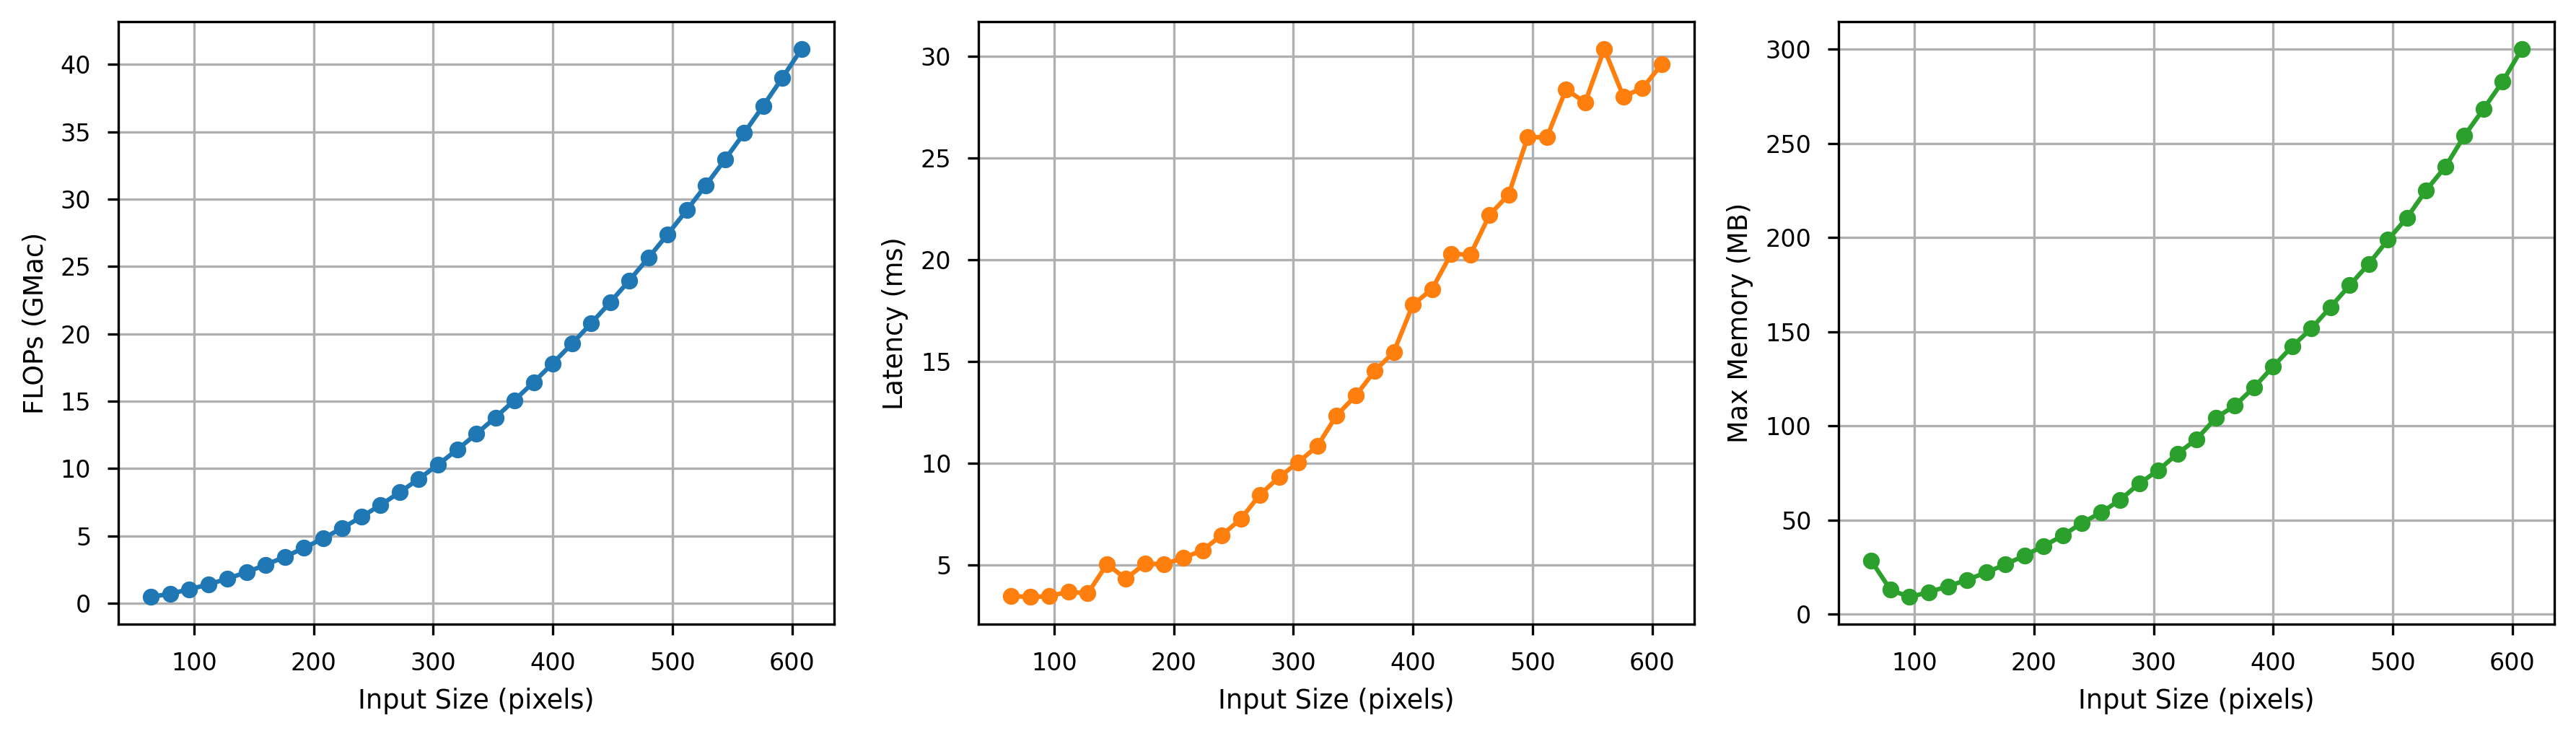

In [ ]:
import torch
import torch.nn as nn
import time
import gc
import matplotlib.pyplot as plt
from ptflops import get_model_complexity_info

# --- Define U-Net ---
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.block(x)

class SimpleUNet(nn.Module):
    def __init__(self, in_ch=5, out_ch=4):
        super().__init__()
        self.enc1 = ConvBlock(in_ch, 32)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = ConvBlock(32, 64)
        self.pool2 = nn.MaxPool2d(2)

        self.bottleneck = ConvBlock(64, 128)

        self.up2 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec2 = ConvBlock(128, 64)
        self.up1 = nn.ConvTranspose2d(64, 32, 2, stride=2)
        self.dec1 = ConvBlock(64, 32)

        self.out_conv = nn.Conv2d(32, out_ch, 1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))
        b = self.bottleneck(self.pool2(e2))
        d2 = self.dec2(torch.cat([self.up2(b), e2], dim=1))
        d1 = self.dec1(torch.cat([self.up1(d2), e1], dim=1))
        return self.out_conv(d1)

# --- Setup ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleUNet().to(device)
model.eval()

input_sizes = [i for i in range(64, 64 + 70*8, 8) if i % 16 == 0]  # safer set with multiples of 16


flops_list, latency_list, memory_list = [], [], []

print(f"{'Input Size':>10} | {'FLOPs (GMac)':>12} | {'Latency (ms)':>12} | {'Max Mem (MB)':>12}")
print("-" * 55)

for size in input_sizes:
    input_shape = (5, size, size)

    # --- FLOPs ---
    try:
        flops, params = get_model_complexity_info(model, input_shape, as_strings=False, print_per_layer_stat=False)
        flops_gmac = flops / 1e9
    except:
        flops_gmac = None

    # --- Latency + Memory ---
    dummy_input = torch.randn(1, *input_shape).to(device)
    torch.cuda.reset_peak_memory_stats(device)
    torch.cuda.empty_cache()
    gc.collect()

    with torch.no_grad():
        start_time = time.time()
        _ = model(dummy_input)
        torch.cuda.synchronize()
        latency_ms = (time.time() - start_time) * 1000
        max_mem = torch.cuda.max_memory_allocated(device) / (1024**2)

    print(f"{size}x{size:>5}   | {flops_gmac if flops_gmac else 'Error':>12} | {latency_ms:12.2f} | {max_mem:12.2f}")

    flops_list.append(flops_gmac if flops_gmac else 0)
    latency_list.append(latency_ms)
    memory_list.append(max_mem)

import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-paper')

# --- Colors ---
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # blue, orange, green

# --- Set figure size for paper (in inches) ---
fig, axs = plt.subplots(1, 3, figsize=(12, 3.5), dpi=300)

# FLOPs plot
axs[0].plot(input_sizes, flops_list, marker='o', color=colors[0], linewidth=1.5, label="FLOPs")
axs[0].set_xlabel("Input Size (pixels)")
axs[0].set_ylabel("FLOPs (GMac)")
axs[0].grid(True)

# Latency plot
axs[1].plot(input_sizes, latency_list, marker='o', color=colors[1], linewidth=1.5, label="Latency")
axs[1].set_xlabel("Input Size (pixels)")
axs[1].set_ylabel("Latency (ms)")
axs[1].grid(True)

# Memory plot
axs[2].plot(input_sizes, memory_list, marker='o', color=colors[2], linewidth=1.5, label="Max Memory")
axs[2].set_xlabel("Input Size (pixels)")
axs[2].set_ylabel("Max Memory (MB)")
axs[2].grid(True)

# Layout + Save
plt.tight_layout()
plt.savefig("irs_complexity_plots.pdf", bbox_inches="tight")
plt.show()



In [ ]:
import matplotlib.pyplot as plt
print(plt.style.available)


['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'petroff10', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


In [ ]:
from google.colab import files
files.download("irs_complexity_plots.pdf")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

W0713 12:58:10.280000 2216 torch/_inductor/utils.py:1137] [0/0] Not enough SMs to use max_autotune_gemm mode


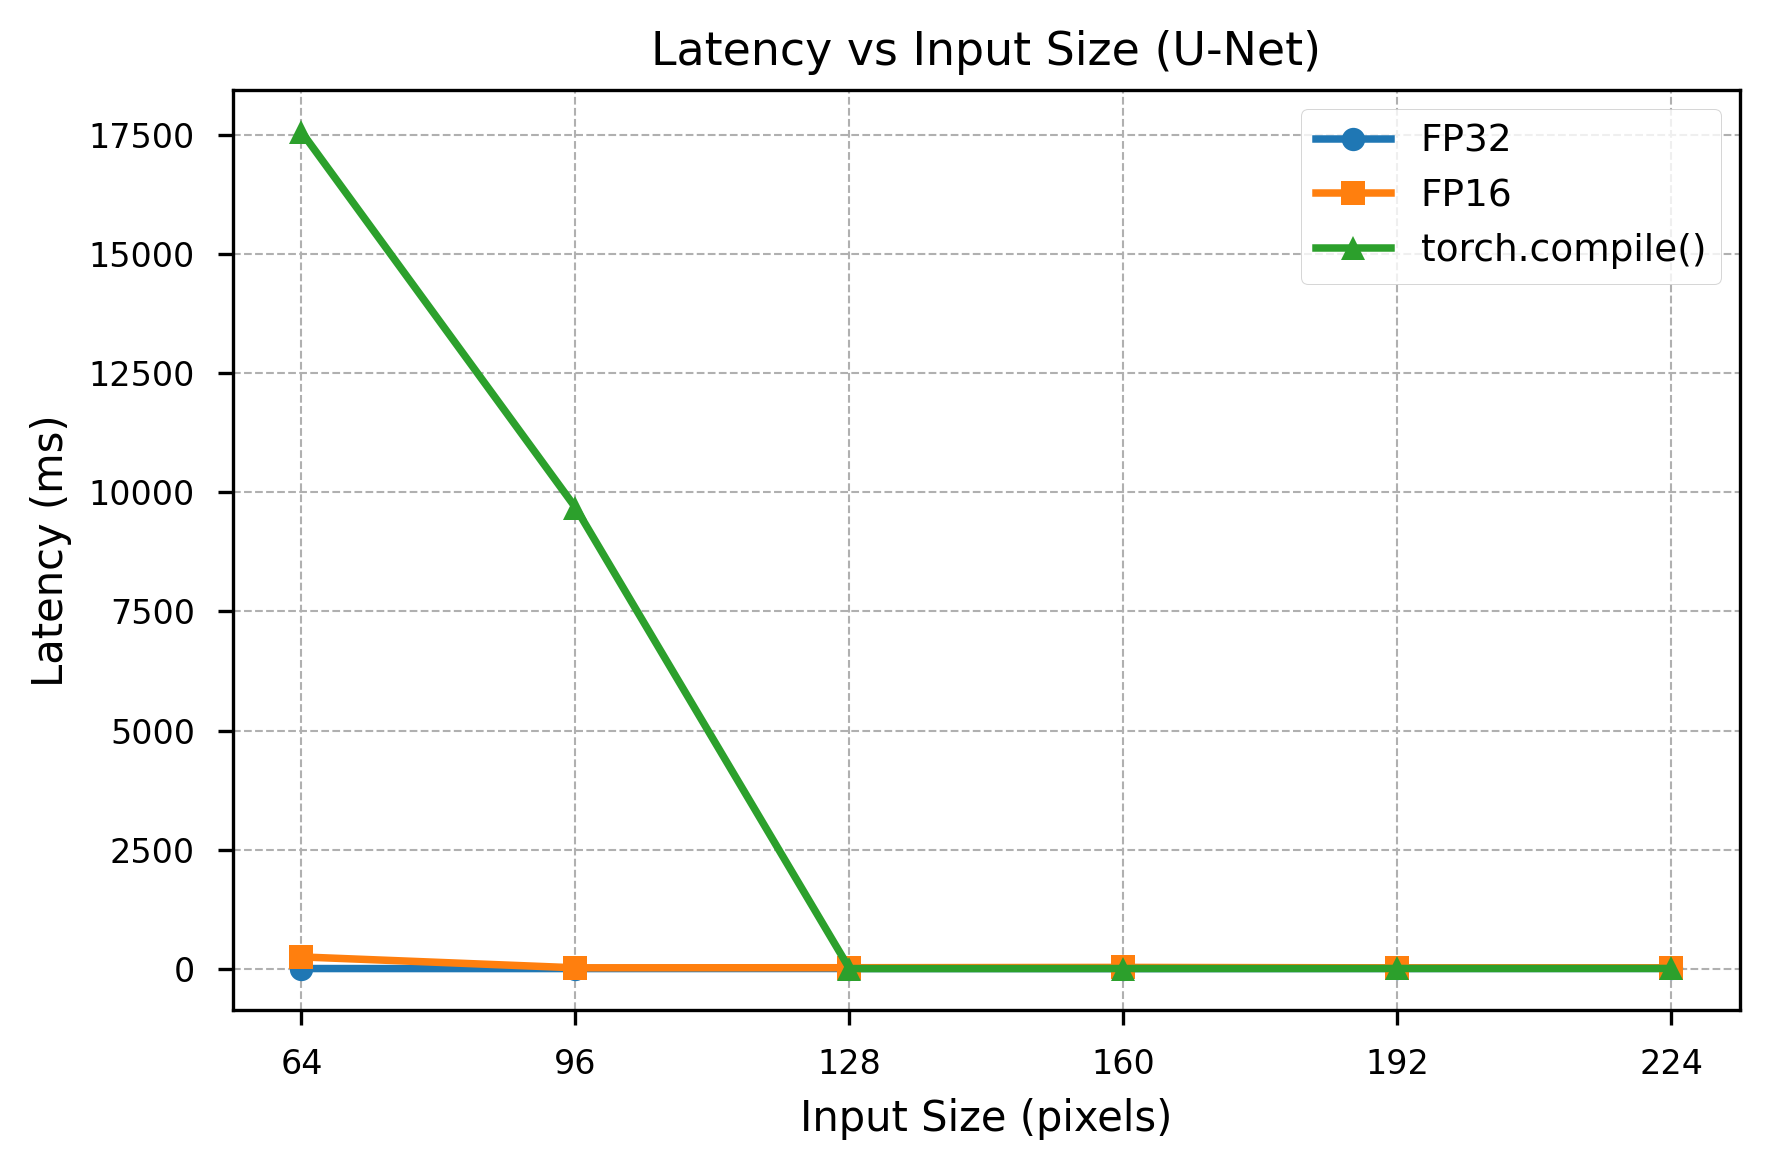

In [ ]:
import torch
import torch.nn as nn
import time
import gc
import matplotlib.pyplot as plt
from ptflops import get_model_complexity_info

# --- Model Definition ---
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.block(x)

class SimpleUNet(nn.Module):
    def __init__(self, in_ch=5, out_ch=4):
        super().__init__()
        self.enc1 = ConvBlock(in_ch, 32)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = ConvBlock(32, 64)
        self.pool2 = nn.MaxPool2d(2)
        self.bottleneck = ConvBlock(64, 128)
        self.up2 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec2 = ConvBlock(128, 64)
        self.up1 = nn.ConvTranspose2d(64, 32, 2, stride=2)
        self.dec1 = ConvBlock(64, 32)
        self.out_conv = nn.Conv2d(32, out_ch, 1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))
        b = self.bottleneck(self.pool2(e2))
        d2 = self.dec2(torch.cat([self.up2(b), e2], dim=1))
        d1 = self.dec1(torch.cat([self.up1(d2), e1], dim=1))
        return self.out_conv(d1)

# --- Setup ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
base_model = SimpleUNet().to(device)
base_model.eval()

valid_input_sizes = [64, 96, 128, 160, 192, 224]
results = {'Input Size': [], 'FLOPs (GMac)': [], 'Latency FP32 (ms)': [], 'Latency FP16 (ms)': [], 'Latency compile() (ms)': [], 'Memory (MB)': []}

for size in valid_input_sizes:
    input_shape = (5, size, size)
    dummy_input = torch.randn(1, *input_shape).to(device)

    try:
        flops, _ = get_model_complexity_info(base_model, input_shape, as_strings=False, print_per_layer_stat=False)
        flops_gmac = flops / 1e9
    except:
        flops_gmac = None

    # --- FP32 Inference ---
    model_fp32 = SimpleUNet().to(device).eval()
    dummy_fp32 = dummy_input.clone()
    torch.cuda.reset_peak_memory_stats(device)
    torch.cuda.empty_cache()
    gc.collect()
    with torch.no_grad():
        start = time.time()
        _ = model_fp32(dummy_fp32)
        torch.cuda.synchronize()
        latency_fp32 = (time.time() - start) * 1000
        mem_fp32 = torch.cuda.max_memory_allocated(device) / 1024**2

    # --- FP16 Inference ---
    model_fp16 = SimpleUNet().half().to(device).eval()
    dummy_fp16 = dummy_input.half()
    torch.cuda.reset_peak_memory_stats(device)
    torch.cuda.empty_cache()
    gc.collect()
    with torch.no_grad():
        start = time.time()
        _ = model_fp16(dummy_fp16)
        torch.cuda.synchronize()
        latency_fp16 = (time.time() - start) * 1000

    # --- Torch.compile() Inference (FP32) ---
    try:
        compiled_model = torch.compile(model_fp32)
        dummy_compile = dummy_input.clone()
        torch.cuda.reset_peak_memory_stats(device)
        torch.cuda.empty_cache()
        gc.collect()
        with torch.no_grad():
            start = time.time()
            _ = compiled_model(dummy_compile)
            torch.cuda.synchronize()
            latency_compile = (time.time() - start) * 1000
    except:
        latency_compile = None

    results['Input Size'].append(f"{size}x{size}")
    results['FLOPs (GMac)'].append(flops_gmac)
    results['Latency FP32 (ms)'].append(latency_fp32)
    results['Latency FP16 (ms)'].append(latency_fp16)
    results['Latency compile() (ms)'].append(latency_compile)
    results['Memory (MB)'].append(mem_fp32)

import matplotlib.pyplot as plt

# Use a clean, paper-ready style
plt.style.use('seaborn-v0_8-paper')

# Plot settings
plt.figure(figsize=(6, 4), dpi=300)
colors = {
    "FP32": '#1f77b4',     # blue
    "FP16": '#ff7f0e',     # orange
    "compile": '#2ca02c'   # green
}

# Plot each latency line
plt.plot(valid_input_sizes, results['Latency FP32 (ms)'],
         label="FP32", marker='o', linewidth=1.8, color=colors["FP32"])

plt.plot(valid_input_sizes, results['Latency FP16 (ms)'],
         label="FP16", marker='s', linewidth=1.8, color=colors["FP16"])

if None not in results['Latency compile() (ms)']:
    plt.plot(valid_input_sizes, results['Latency compile() (ms)'],
             label="torch.compile()", marker='^', linewidth=1.8, color=colors["compile"])

# Axes and labels
plt.xlabel("Input Size (pixels)", fontsize=10)
plt.ylabel("Latency (ms)", fontsize=10)
plt.title("Latency vs Input Size (U-Net)", fontsize=11)
plt.xticks(valid_input_sizes)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend(fontsize=9)
plt.tight_layout()

# Save high-res version for paper use
plt.savefig("unet_latency_comparison.pdf", bbox_inches='tight')
plt.show()


In [ ]:
files.download("unet_latency_comparison.pdf")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Batch size 1: 3.58 ms
Batch size 2: 7.32 ms
Batch size 4: 14.22 ms
Batch size 8: 32.37 ms
Batch size 16: 69.60 ms
Batch size 32: 147.28 ms
Batch size 64: 257.14 ms


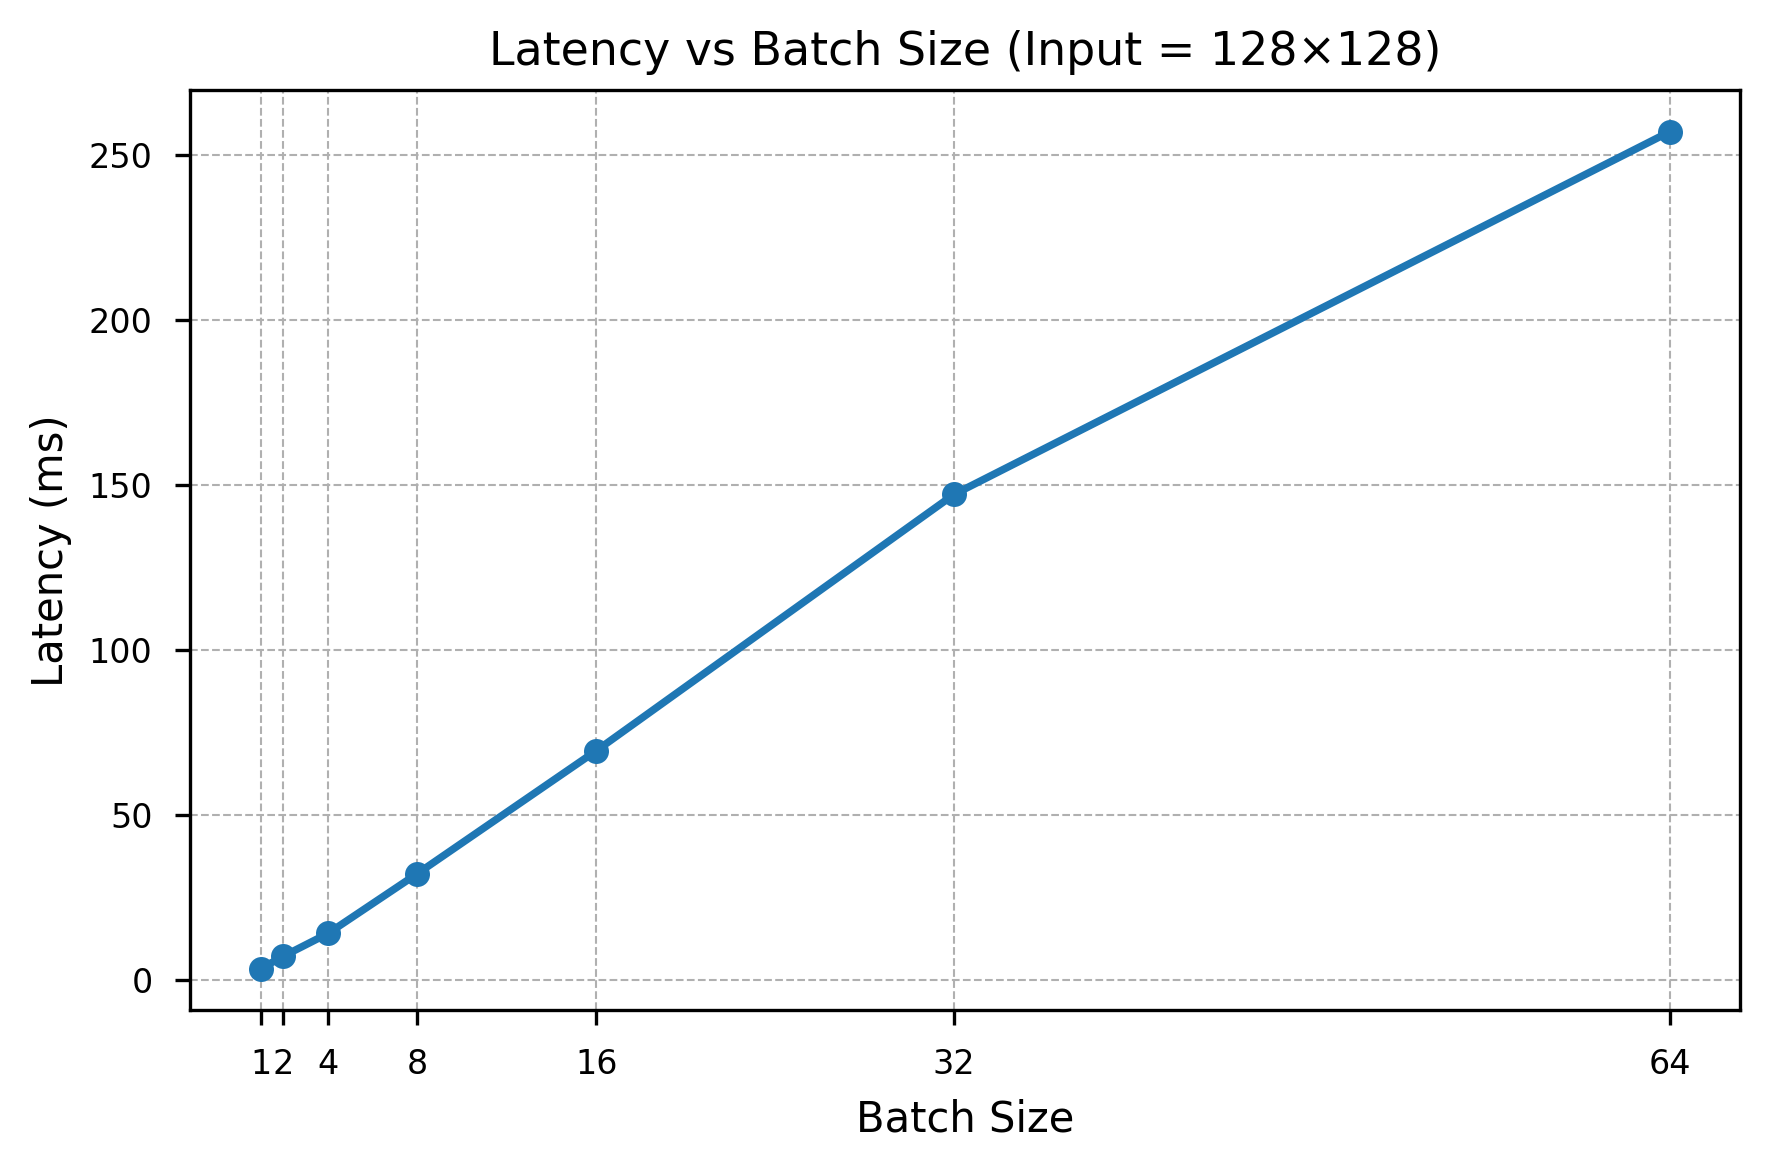

In [ ]:
import torch
import torch.nn as nn
import time
import matplotlib.pyplot as plt
import gc

# --- U-Net Definition (if not already in notebook) ---
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.block(x)

class SimpleUNet(nn.Module):
    def __init__(self, in_ch=5, out_ch=4):
        super().__init__()
        self.enc1 = ConvBlock(in_ch, 32)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = ConvBlock(32, 64)
        self.pool2 = nn.MaxPool2d(2)
        self.bottleneck = ConvBlock(64, 128)
        self.up2 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec2 = ConvBlock(128, 64)
        self.up1 = nn.ConvTranspose2d(64, 32, 2, stride=2)
        self.dec1 = ConvBlock(64, 32)
        self.out_conv = nn.Conv2d(32, out_ch, 1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))
        b = self.bottleneck(self.pool2(e2))
        d2 = self.dec2(torch.cat([self.up2(b), e2], dim=1))
        d1 = self.dec1(torch.cat([self.up1(d2), e1], dim=1))
        return self.out_conv(d1)

# --- Setup ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleUNet().to(device)
model.eval()

# --- Batch Sizes & Input Shape ---
input_resolution = 128
batch_sizes = [1, 2, 4, 8, 16, 32, 64]
latencies = []

# --- Measure Latency for Each Batch Size ---
for batch_size in batch_sizes:
    input_tensor = torch.randn(batch_size, 5, input_resolution, input_resolution).to(device)
    torch.cuda.empty_cache()
    gc.collect()
    torch.cuda.reset_peak_memory_stats(device)

    # Warm-up
    with torch.no_grad():
        for _ in range(3):
            _ = model(input_tensor)

    # Measure latency
    with torch.no_grad():
        start = time.time()
        _ = model(input_tensor)
        torch.cuda.synchronize()
        end = time.time()

    latency = (end - start) * 1000  # ms
    latencies.append(latency)

    print(f"Batch size {batch_size}: {latency:.2f} ms")

import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-paper')

# Colors and markers
color = '#1f77b4'  # Blue
marker = 'o'

# Plot
plt.figure(figsize=(6, 4), dpi=300)
plt.plot(batch_sizes, latencies, marker=marker, color=color, linewidth=1.8, markersize=6)

plt.xlabel("Batch Size", fontsize=10)
plt.ylabel("Latency (ms)", fontsize=10)
plt.title(f"Latency vs Batch Size (Input = {input_resolution}×{input_resolution})", fontsize=11)
plt.xticks(batch_sizes)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()

# Save & show
plt.savefig("batchsize_latency_plot.pdf", bbox_inches="tight")
plt.show()



In [ ]:
files.download("batchsize_latency_plot.pdf")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>